# RNASeq Classifier

In [30]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pandas import read_csv, DataFrame, Series
import pandas as pd
from sklearn.model_selection import train_test_split
from helper import *
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [ ]:
# create .csv from .matrix

# with open("19NQ013_samples.matrix") as textFile:
#     data = np.array([sample.split() for sample in textFile])
#
# with open('19NQ013_samples.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(data)

In [3]:
samples = read_csv('19NQ013_samples.csv')

#### Prepare data

In [4]:
# leave only OT_ and CR_ patients
drop_list = []
for patient in samples.columns:
    if patient[:2] != 'OT' and patient[:2] != 'CR':
        drop_list.append(patient)
genes = samples['genes'].to_list()
samples = samples.drop(drop_list[1:],axis=1)

In [5]:
# recode patient status to numeric (OT = 0, CR = 1)
patients = samples.columns[1:]
patients_labels = pd.DataFrame({'status':  [p[:2] for p in patients]})
print('Patients amount: \n', patients_labels.value_counts())

patients_labels = patients_labels.replace({'OT':0, 'CR':1})
labels = ['OT', 'CR']

Patients amount: 
 status
OT        15
CR        12
dtype: int64


#### Filter data

In [6]:
print('Number of all genes: ', samples.sum(axis=1).count())

Number of all genes:  187626


In [7]:
print('Number of genes which have > 10 counts: ', (samples.sum(axis=1) > 20).value_counts())
print('Number of genes which have a least 4 counts in one of vzorku: ', (samples.max(axis=1) > 4).value_counts())

Number of genes which have > 10 counts:  False    104301
True      83325
dtype: int64
Number of genes which have a least 4 counts in one of vzorku:  False    119072
True      68554
dtype: int64


In [8]:
# remove genes with < 20 read counts in all samples and genes which have > 5 read counts in at least one sample
samples = samples[(samples.sum(axis=1) > 20) & (samples.max(axis=1) > 5)]

In [ ]:
# remove genes with zero counts in all samples
# print('Number of zero gene expression: ', (samples.sum(axis=1) <= 1).sum())
# samples = samples[samples.sum(axis=1) > 1]

# remove genes with a low mean normalized counts
# mean = samples.mean(axis=1)
# print('Number of genes with low mean counts: ', mean[mean < 2].count())
# samples = samples[mean > 2]

# print('Number of all genes after removing: ', samples.sum(axis=1).count())
# samples.head()

# remove genes with an extreme count outlier
# zsc = np.abs(stats.zscore(samples[samples.columns[1:]]))
# print(zsc[zsc>100])
# print(samples[(zsc > 3).all(axis=1)])
# samples = samples[(np.abs(stats.zscore(samples)) < 3).all(axis=1)]

In [9]:
print('Number of all genes after data filtering: ', samples.sum(axis=1).count())

Number of all genes after data filtering:  58526


#### Prepare dataset for classification


In [10]:
# transpose
samples = samples.transpose()
samples.columns = samples.iloc[0]
samples = samples.drop(["genes"]).apply(pd.to_numeric)
samples = samples.reset_index(drop=True)
samples.head()

genes,ENST00000390396.1,ENST00000390400.2,ENST00000390369.2,ENST00000390468.1,ENST00000390424.2,ENST00000390463.3,ENST00000390440.2,ENST00000390436.2,ENST00000390435.1,ENST00000631690.1,...,ENST00000499853.2,ENST00000383620.4,ENST00000563214.1,ENST00000626385.1,ENST00000617319.1,ENST00000646111.1,ENST00000647527.1,ENST00000634119.1,ENST00000631343.1,ENST00000635730.1
0,0,6,3,4,0,0,2,4,3,2,...,5,13,0,2,1,2,1,3,0,0
1,1,12,0,7,5,3,5,5,12,3,...,5,9,2,5,2,5,4,1,2,3
2,1,4,0,4,3,2,4,12,12,0,...,6,7,3,7,3,3,1,0,0,0
3,1,2,0,4,0,1,1,4,0,0,...,4,0,2,2,1,5,4,4,0,1
4,0,8,0,5,8,2,5,6,14,2,...,6,22,1,4,1,7,7,1,1,0


#### Initialize train and test data

In [ ]:
# split samples into train and test subsets (randomly!)
# X_train, X_test, y_train, y_test = train_test_split(samples, patients_labels, test_size=0.5)
# print('Train subset: (0 = OT, 1 = CR)\nid', y_train)
# print('Test subset: (0 = OT, 1 = CR)\nid', y_test)

#### 5x20 cross validation for future selection


In [69]:
n_splits = 5
genes_range = [3, 5, 10, 30, 100] # number of selected genes
results = dict((k, []) for k in genes_range)
signatures = dict((k, dict()) for k in genes_range)
selected_features = dict((k, dict()) for k in genes_range)

# cross validation
# cv = StratifiedKFold(n_splits=n_splits).split(X, y)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=20).split(X, y)
for i, (train_idx, test_idx) in enumerate(cv):
    X_train, y_train = [X.iloc[train_idx, :], y.iloc[train_idx]]
    X_test, y_test = [X.iloc[test_idx, :], y.iloc[test_idx]]

    for selected_k in genes_range:
        # print('\nNumber of genes: ', selected_k)

        # feature selection
        selected_genes = dict()
        selected_genes['Random'] = feature_selection_random(X_train, selected_k)
        selected_genes['Extra trees'] = feature_selection_extra_trees(X_train, y_train.values.ravel(), selected_k)
        selected_genes['Lasso'] = feature_selection_l1(X_train, y_train.values.ravel(), selected_k)

        auc_scores = []
        for name, genes in selected_genes.items():
            X_train_selected = X_train[genes]
            X_test_selected = X_test[genes]

            # model prediction
            model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train_selected, y_train.values.ravel())
            probabilities = model.predict_proba(X_test_selected)[:, 1]

            # calculate auroc score
            auc = roc_auc_score(y_test, probabilities)
            # if auc < 0.4:
            #     print('auc = ', auc)
            #     print(y_test)
            #     print(probabilities)
            #     print('---')
            auc_scores.append(auc)

            if name != 'Random':
                sgntr = tuple(genes)
                signatures[selected_k][sgntr] = selected_features[selected_k][sgntr] + 1 if sgntr in selected_features[selected_k] else 1
                for g in genes:
                    selected_features[selected_k][g] = selected_features[selected_k][g] + 1 if g in selected_features[selected_k] else 1

        results[selected_k].append(auc_scores)

#### Show cross-validation results

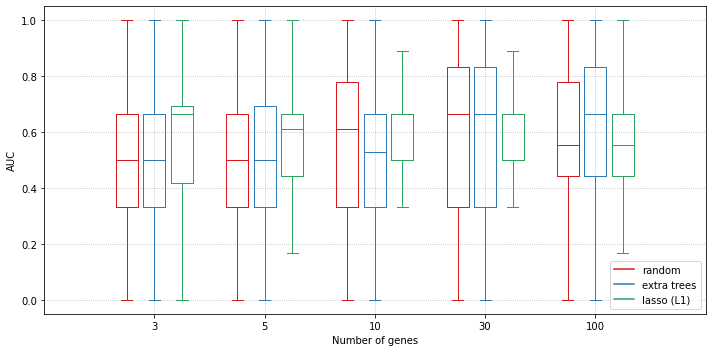

In [70]:
# modify data for boxplots
methods_names = ['random', 'extra trees', 'lasso (L1)']
data_groups = group_data(results)
# print(data_groups)

# show boxplots
show_cv(data_groups, genes_range, methods_names)

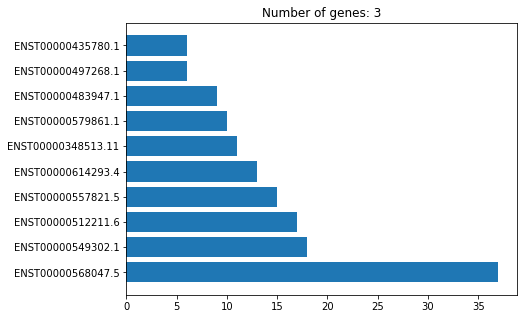

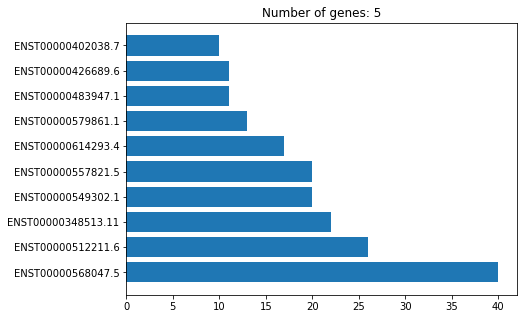

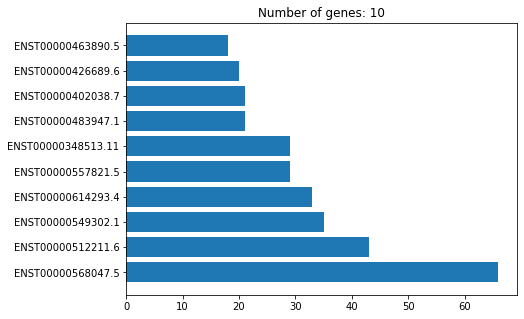

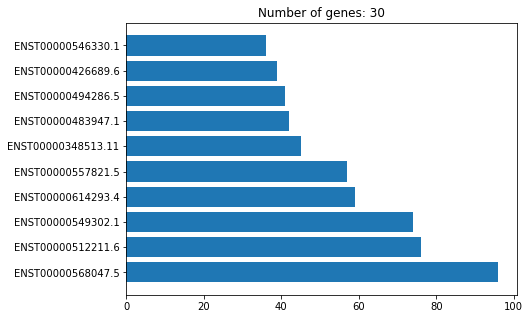

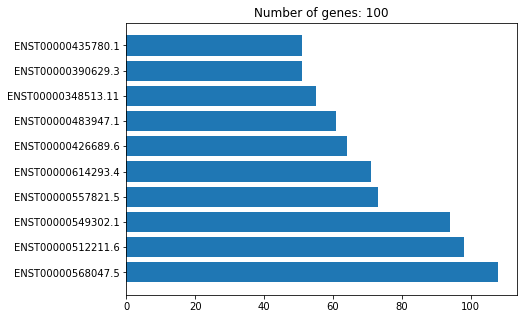

In [87]:
# selected features
ind = 0
for k, genes in selected_features.items():
    sorted_genes = dict(sorted(genes.items(), key=lambda item: item[1], reverse=True))

    n = 10
    top_n_genes = list(sorted_genes.items())[:n]
    # print(top_n_genes)

    plt.figure(figsize=(7,5))
    x_coord, y_coord = tuple(zip(*top_n_genes))
    plt.barh(x_coord, y_coord)
    plt.title('Number of genes: {}'.format(k))
    plt.savefig('featureselection{}.png'.format(ind))
    ind += 1


#### Add information about immunosuppressive drugs

In [20]:
# Load data
samples_IS = read_csv('Kodovani_skupin_proDEG_vlivIS.csv')

patients_tmp = patients.copy()
patients_tmp = patients_tmp.to_frame(index=False).replace(to_replace=r'^OT_', value='T', regex=True)
patients_tmp.columns = ['RNA_seq_label']
samples_IS = pd.merge(patients_tmp, samples_IS, on='RNA_seq_label')

In [21]:
# Add IS to other feature variables
samples_IS = samples_IS.drop(samples_IS.columns[:4], axis=1)
samples_IS.columns = ['CNI', 'steroids', 'antiproliferative_drugs']
samples_genes_IS = pd.concat([samples_IS, samples], axis=1).reindex(samples_IS.index)
samples_genes_IS.head()

,CNI,steroids,antiproliferative_drugs,ENST00000390396.1,ENST00000390400.2,ENST00000390369.2,ENST00000390468.1,ENST00000390424.2,ENST00000390463.3,ENST00000390440.2,...,ENST00000499853.2,ENST00000383620.4,ENST00000563214.1,ENST00000626385.1,ENST00000617319.1,ENST00000646111.1,ENST00000647527.1,ENST00000634119.1,ENST00000631343.1,ENST00000635730.1
0,0,0,0,0,6,3,4,0,0,2,...,5,13,0,2,1,2,1,3,0,0
1,0,0,0,1,12,0,7,5,3,5,...,5,9,2,5,2,5,4,1,2,3
2,0,0,0,1,4,0,4,3,2,4,...,6,7,3,7,3,3,1,0,0,0
3,0,0,0,1,2,0,4,0,1,1,...,4,0,2,2,1,5,4,4,0,1
4,0,0,0,0,8,0,5,8,2,5,...,6,22,1,4,1,7,7,1,1,0


##### Cross validation
###### (the result of the classification will be too good, because in this case we do not consider immunosuppressants as confounders)

In [23]:
X = StandardScaler().fit_transform(samples_genes_IS)
y = patients_labels
X = pd.DataFrame(data=X, columns=samples_genes_IS.columns) # normilize
X.head()

,CNI,steroids,antiproliferative_drugs,ENST00000390396.1,ENST00000390400.2,ENST00000390369.2,ENST00000390468.1,ENST00000390424.2,ENST00000390463.3,ENST00000390440.2,...,ENST00000499853.2,ENST00000383620.4,ENST00000563214.1,ENST00000626385.1,ENST00000617319.1,ENST00000646111.1,ENST00000647527.1,ENST00000634119.1,ENST00000631343.1,ENST00000635730.1
0,-0.894427,-0.829156,-0.829156,-0.723095,0.081449,1.378450,-0.444500,-1.311745,-1.078328,-0.749931,...,0.212143,1.648595,-1.110771,-0.473146,-0.868243,-0.386230,-1.072232,1.227144,-0.752217,-0.736619
1,-0.894427,-0.829156,-0.829156,-0.324655,1.400923,-0.651631,0.841376,0.358874,0.377415,0.028843,...,0.212143,0.924822,0.113344,1.268891,-0.310087,1.260329,0.451466,-0.153393,0.316723,0.718653
2,-0.894427,-0.829156,-0.829156,-0.324655,-0.358376,-0.651631,-0.444500,-0.309374,-0.107833,-0.230748,...,0.784928,0.562935,0.725402,2.430248,0.248069,0.162623,-1.072232,-0.843661,-0.752217,-0.736619
3,-0.894427,-0.829156,-0.829156,-0.324655,-0.798200,-0.651631,-0.444500,-1.311745,-0.593080,-1.009522,...,-0.360642,-0.703669,0.113344,-0.473146,-0.868243,1.260329,0.451466,1.917412,-0.752217,-0.251529
4,-0.894427,-0.829156,-0.829156,-0.723095,0.521274,-0.651631,-0.015875,1.361244,-0.107833,0.028843,...,0.784928,3.277085,-0.498714,0.688212,-0.868243,2.358035,1.975164,-0.153393,-0.217747,-0.736619


In [24]:
n_splits = 5
genes_range = [3, 5, 10, 30, 100] # number of selected genes
resultsIS = dict((k, []) for k in genes_range)
selected_featuresIS = dict((k, dict()) for k in genes_range)

# cross validation
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=20).split(X, y)
for i, (train_idx, test_idx) in enumerate(cv):
    X_train, y_train = [X.iloc[train_idx, :], y.iloc[train_idx]]
    X_test, y_test = [X.iloc[test_idx, :], y.iloc[test_idx]]

    for selected_k in genes_range:
        # print('\nNumber of genes: ', selected_k)

        # feature selection
        selected_genes = dict()
        selected_genes['Random'] = feature_selection_random(X_train, selected_k)
        selected_genes['Extra trees'] = feature_selection_extra_trees(X_train, y_train.values.ravel(), selected_k)
        selected_genes['Lasso'] = feature_selection_l1(X_train, y_train.values.ravel(), selected_k)

        auc_scores = []
        for name, genes in selected_genes.items():
            X_train_selected = X_train[genes]
            X_test_selected = X_test[genes]

            # model prediction
            model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train_selected, y_train.values.ravel())
            probabilities = model.predict_proba(X_test_selected)[:, 1]

            # calculate auroc score
            auc = roc_auc_score(y_test, probabilities)
            auc_scores.append(auc)

            if name != 'Random':
                for g in genes:
                    selected_featuresIS[selected_k][g] = selected_features[selected_k][g] + 1 if g in selected_features[selected_k] else 1

        resultsIS[selected_k].append(auc_scores)

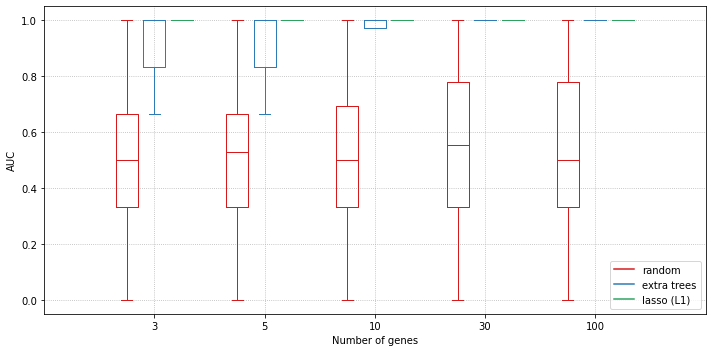

In [32]:
# modify data for boxplots
methods_names = ['random', 'extra trees', 'lasso (L1)']
data_groups = group_data(resultsIS)
# print(data_groups)

# show boxplots
show_cv(data_groups, genes_range, methods_names)